<a href="https://colab.research.google.com/github/ooootaaaa/DeepLearning2022Late/blob/main/1129%5BSelenium%E3%81%A7%E7%94%BB%E5%83%8F%E5%8F%8E%E9%9B%862022%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##seleniumを使って自動で画像検索し、結果を収集する

##必要なアプリのインストール
###Seleniumのインストール(バージョンを指定する)

In [1]:
!pip install selenium==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###chromium-chromedriverのインストール

In [2]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (108.0.5359.71-0ubuntu0.18.04.5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


##seleniumを実行して操作する

###その他のライブラリのimport

In [3]:
import requests
from selenium import  webdriver
from selenium.webdriver.chrome.options import Options
import os
import time
import datetime
#エラー処理用
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


##ログ用に時刻を取得

In [4]:
tm_start = time.time()#処理時間計測用
dt_now = datetime.datetime.now()#現在時間
dt_date_str = dt_now.strftime('%Y/%m/%d %H:%M')#書式指定
print(dt_date_str)

2022/12/12 02:31


##検索に関する設定値を定義する

In [5]:
QUERY = '犬 フリー'#検索したいワード
LIMIT_DL_NUM = 100#ダウンロード数の上限
SAVE_DIR = 'img/dog_'#出力フォルダ(自動生成させる)
FILE_NAME = 'dog_'#ファイル名(後ろに連番と拡張子をつけていく)
TIMEOUT = 60 #検索のタイムアウト(秒)
ACCESS_WAIT = 1 #アクセスする間隔(秒)←超重要
RETRY_NUM = 3 #クリックやrequestのリトライ回数
DRIVER_PATH = '/usr/bin/chromedriver'#chromedriver.exeへのパス

##Chromeをヘッドレスモードで起動する
ヘッドレスモード = ブラウザを画面に開かないで実行するモード

In [6]:
# optionの指定を準備
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('start-fullscreen')
options.add_argument('--disable-plugins')
options.add_argument('--disable-extensions')
#起動する
driver= webdriver.Chrome(DRIVER_PATH,options=options)
driver.implicitly_wait(TIMEOUT)#タイムアウト指定
#ログに処理時間を出力
tm_driver = time.time()
print('WebDriver起動完了',f'{tm_driver - tm_start:.1f}s')

<ipython-input-6-c7e25328e71c>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver= webdriver.Chrome(DRIVER_PATH,options=options)


WebDriver起動完了 0.9s


##Googleの画像検索へアクセス

In [7]:
#QUERY条件付きでURLを定義する
url = f'https://www.google.com/search?q={QUERY}&tbm=isch'
#組み立てたURLでアクセスで検索
driver.get(url)
#時刻のログを取得
tm_geturl = time.time()
print('Google画像検索ページ取得',f'{tm_geturl - tm_driver:.1f}s')


Google画像検索ページ取得 2.0s


##検索結果の要素を取得していく

In [8]:
#ページのサムネイル画像の要素群を取得
#(islmpクラスが指定されたimg=サムネイルを全て拾う)
tmb_elems = driver.find_elements_by_css_selector('#islmp img')
#サムネイルのリストから各サムネイルのalt属性を取得
tmb_alts = [tmb.get_attribute('alt') for tmb in tmb_elems]
#alt属性が空(小さいサムネイル)のものを差し引いて合計を算出
count = len(tmb_alts) - tmb_alts.count('')
print(count)

<ipython-input-8-9530cefa3356>:3: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems = driver.find_elements_by_css_selector('#islmp img')


48


##下にスクロールさせてさらに検索結果を表示させてまたカウント

In [9]:

#定義したLIMIT_DL_NUM(ダウンロード数の上限)になるまでスクロールを繰り返す
while count < LIMIT_DL_NUM:
  #ページの一番下へスクロールして新しいサムネイル画像を表示させる
  driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
  time.sleep(1) #スリープを繰り返す間隔(秒)を入れる　←重要
  #(islmpクラスが指定されたimg=サムネイルを全て拾う)
  tmb_elems = driver.find_elements_by_css_selector('#islmp img')
  #サムネイルのリストから各サムネイルのalt属性を取得
  tmb_alts = [tmb.get_attribute('alt') for tmb in tmb_elems]
  #alt属性が空(小さいサムネイル)のものを差し引いて合計を算出
  count = len(tmb_alts) - tmb_alts.count('')
  print(count)


<ipython-input-9-8a2fc6b3e78d>:7: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems = driver.find_elements_by_css_selector('#islmp img')


100


##サムネイル画像をクリックすると右側に開かれる領域をオブジェクトに取得

In [10]:
imgframe_elem = driver.find_element_by_id(('islsp'))


<ipython-input-10-bccfe8b3b005>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  imgframe_elem = driver.find_element_by_id(('islsp'))


##画像へURLアクセスした保存する準備をする

In [11]:
#画像の保存フォルダを作成
os.makedirs(SAVE_DIR,exist_ok=True)
#HTTPリクエスト用のヘッダーを作る
HTTP_HEADERS = {'User-Aget':driver.execute_script('return navigator.userAgent;')}
print(HTTP_HEADERS)
#ダウンロードしたい対象のファイル拡張子
IMG_EXTS = ('.jpg','.jpeg','.png','.gif')

{'User-Aget': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/108.0.5359.71 Safari/537.36'}


##ダウンロード中に利用する関数を定義
###画像の拡張子を取得する関数

In [12]:
#拡張子を取得する関数
def get_exetension(url):
  url_lower = url.lower()
  for img_ext in IMG_EXTS:#拡張子のリストから1つずつ比較
    if img_ext in url_lower:
      extension = '.jpg' if img_ext == '.jpeg' else img_ext
      break
    #if終わり
    else:
      extension = ''
    #for終わり
  return extension
#関数終わり

###urlで指定した画像へアクセスし、フォルダ内のファイルとして書き込む

In [13]:
def download_image(url,path,loop):
  result = False #戻り値の変数
  for i in range(loop):
    try:
      r = requests.get(url,headers=HTTP_HEADERS, stream=True, timeout=10)
      r.raise_for_status()
      with open(path,'wb') as f:#バイナリ書き込むモードで開く
        f.write(r.content)
    except requests.exceptions.SSLError:
      print('****** SSL エラー')
      break #リトライしない
    except requests.exceptions.RequestException as e:
      print(f'***** requests エラー({e}): {i +1}/{RETRY_NUM}')
      time.sleep(1)
    else:
      result = True
      break #try成功
    #ループ終わり
  #関数終わり

###サムネイルを取得し、画像ダウンロードの準備ができたタイミング

In [14]:
tm_thumbnails = time.time()
print('サムネイル画像取得とDL準備完了',f'{tm_thumbnails - tm_geturl:.1f}s')

サムネイル画像取得とDL準備完了 6.1s


###ダウンロード処理

0:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK


/usr/local/lib/python3.8/dist-packages/selenium/webdriver/remote/webelement.py:484: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


1:犬 | フリー素材ドットコム
2:へっくしょん（犬）の写真素材 - ぱくたそ
3:怠惰な秋田犬の写真素材 - ぱくたそ
4:犬 | フリー素材ドットコム
5:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
6:画像素材なら！無料・フリー写真素材のフリーフォト
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

6:フリー写真] 芝生を駆ける二匹の子犬でアハ体験 - GAHAG | 著作権フリー写真・イラスト素材集
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

6:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
7:犬（戌）」をテーマにした無料写真素材10選（商用利用可） | ACワークスのブログ
8:犬・チワワ | 無料の高画質フリー写真素材 | イメージズラボ
9:フリー写真素材|動物|哺乳類|イヌ科|犬・イヌ|子犬・小犬|柴犬 ... | Dog blog, Shiba inu, Cute animals
10:犬のイラスト-無料イラストフリー素材
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

10:犬のフリーアイコン｜可愛いフリーアイコン・イラストの無料素材サイト｜フリーペンシル
11:フリー写真] 耳の垂れた犬 - パブリックドメインQ：著作権フリー画像素材集
12:無料で使える 犬 フリー素材 - 使える写真ギャラリーSothei
13:23,754+以上の無料犬画像
14:犬 のストック写真、ロイヤリティフリーの画像、ベクター、およびビデオ | Adobe Stock
15:走る犬 シュナウザーのフリー素材｜無料写真素材集＞dog0173-022＞ダウンロード 高解像度画像 無料写真素材のプロ・フォト
16:犬（戌）」をテーマにした無料イラスト素材10選（商用利用可） | ACワークスのブログ
17:犬 ハイタッチの写真素材｜写真素材なら「写真AC」無料
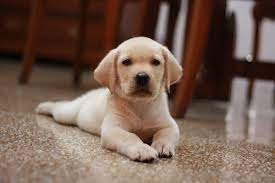
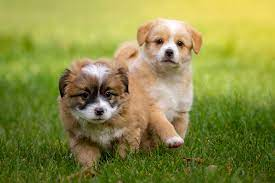
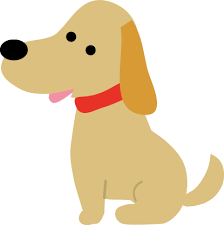

In [15]:
EXCLUSION_URL = 'https//lh3.googleusercontent.com/'#除外対象URL
count=0
url_list=[]
#サムネイルをクリック、画像リンクを取得、画像をDL＆保存を繰り返す
for tmb_elem,tmb_alt in zip(tmb_elems,tmb_alts):
  if tmb_alt == '': ##ALT属性が空==小さい
    continue
  print(f'{count}:{tmb_alt}')#カウンタとALT属性で表示
  #リトライ回数分だけ試行
  for i in range(RETRY_NUM):
    #サムネイルをクリック
    try:
      tmb_elem.click()
    except ElementClickInterceptedException:
      print(f'***** click エラー: {i+1}/{RETRY_NUM}')
      #フォーカスをあわせる
      driver.execute_script('arguments[0].scrollIntoView(true);',tmb_elem)
      time.sleep(1)
    else:
      break #try(クリック成功)
  else:
    print('***** キャンセル')
    continue#リトライ失敗、次のアイコンにスキップ
  #クリック成功したら、処理を続ける
  time.sleep(ACCESS_WAIT)
  #alt属性
  alt = tmb_alt.replace("'","\\")
  try:
    #左側のalt属性を基に左側の大きな画像をalt属性を指定して取得
    img_elem = imgframe_elem.find_element_by_css_selector(f'img[alt=\'{alt}\']')

  except NoSuchElementException:
    print('***** img要素検索エラー')
    print('***** キャンセル')
    continue #次のサムネイルへスキップ
  #右の大きな画像オブジェクトが取得出来たら、その画像リンクを取得する
  tmb_url = tmb_elem.get_attribute('src')#src属性からリンクurlを取得

  #リトライしながらURLをチェック
  for i in range(RETRY_NUM):
    #大きい画像のURL
    url = img_elem.get_attribute('src')
    if EXCLUSION_URL in url:
      print('除外対象url')
      url=''
      break
    elif url == tmb_url:#サムネイルのurlと一緒なら、リトライを続ける
      print(f'***** urlチェック:{i+1}/{RETRY_NUM}')
    else:
      break#ループ中断(除外対象でもサムネイルでもない、OKなurl)
      #RETRYループ終わり
    #URLチェックの結果、OKなリンクでなければ次のサムネイルへスキップ
  if url == '':
    print('***** キャンセル')#大きなループをcontinue
    continue
  #url先の拡張子が指定の画像拡張子でなければ次のサムネイルへスキップ
  ext = get_exetension(url)#自作の関数で拡張子を取得
  if ext == '':#指定の画像拡張子出ない場合
    print(f'***** urlに拡張子が含まれていないのでキャンセル')
    print(f'{url}')
    continue

  #ダウンロード周り:保存するファイルパスを指定する
  filename = f'{FILE_NAME}{count}{ext}'
  path = SAVE_DIR + '/' + filename
  #ダウンロードを実行(自作関数を呼び出す)
  result = download_image(url,path,RETRY_NUM)
  if result == False:
    print('***** キャンセル')
    continue #次のサムネイルへスキップ
    #ダウンロードしたURLをリストに追加
    url_list.append(f'{filename}:{url}')
  #最後に、ダウンロード数カウンタの更新と終了判定
  count += 1
  if count >= LIMIT_DL_NUM:
    break#ダウンロードのループを終了
#ループ終わり
#終了時間の表示
tm_end = time.time()#現在時刻
print('ダウンロード', f'{tm_end - tm_thumbnails:.1f}s')
print('-------------------------')

##Golabo上へダウンロードしたファイルをipで固めてローカルにダウンロードする

In [16]:
#ここまでのトータル所要時間を出力する
total = tm_end - tm_start
total_str = f'トータル時間:{total:.1f}s({total/60:.2f}min)'
count_str = f'ダウンロード数:{count}'
print(total_str)
print(count_str)

トータル時間:180.8s(3.01min)
ダウンロード数:89


##Google検索してダウンロードした画像のURLもテキストに保存してローカルPCへダウンロードする

In [19]:
#URLを書き込むテキストファイルの場所
DIR_TMP = SAVE_DIR + '/url/'
os.makedirs(DIR_TMP,exist_ok=True)
path = SAVE_DIR + '/url/'+'_url.txt'
with open(path,'w',encoding='utf-8') as f:
  f.write(dt_date_str + '\n')
  f.write(total_str + '\n')
  f.write('\n'.join(url_list))
#open ここまで
driver.quit()#ブラウザを閉じる

##URLテキストと画像ファイルをローカルPCにダウンロード

In [20]:
#ダウンロードしたフォルダをzipに圧縮する
!zip -r /content/img_download.zip /content/img
#圧縮したzipファイルをダウンロードする
from google.colab import files
files.download("/content/img_download.zip")



  adding: content/img/ (stored 0%)
  adding: content/img/dog_/ (stored 0%)
  adding: content/img/dog_/dog_78.jpg (deflated 6%)
  adding: content/img/dog_/dog_79.jpg (deflated 14%)
  adding: content/img/dog_/dog_51.png (deflated 2%)
  adding: content/img/dog_/dog_15.jpg (deflated 0%)
  adding: content/img/dog_/dog_34.png (deflated 11%)
  adding: content/img/dog_/dog_62.jpg (deflated 3%)
  adding: content/img/dog_/dog_3.jpg (deflated 0%)
  adding: content/img/dog_/dog_71.jpg (deflated 1%)
  adding: content/img/dog_/dog_42.jpg (deflated 1%)
  adding: content/img/dog_/dog_61.jpg (deflated 17%)
  adding: content/img/dog_/dog_27.jpg (deflated 9%)
  adding: content/img/dog_/dog_58.jpg (deflated 3%)
  adding: content/img/dog_/dog_30.png (deflated 1%)
  adding: content/img/dog_/dog_65.png (deflated 4%)
  adding: content/img/dog_/dog_25.jpg (deflated 1%)
  adding: content/img/dog_/dog_86.jpg (deflated 0%)
  adding: content/img/dog_/dog_38.jpg (deflated 1%)
  adding: content/img/dog_/dog_24.jpg (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>